In [36]:
import pandas as pd

fed_files = ["MORTGAGE30US.csv", "RRVRUSQ156N.csv", "CPIAUCSL.csv"]

dfs = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]
#Here the all the dataframes are on different timelines where one is quarterly, monthly, and weekly so we need to merge them into one big dataframe

fed_data = pd.concat(dfs, axis = 1)

fed_data #Here all the dfs are now merged with different missing values since they are all on different timelines still 
#In order to fix this we can fill the missing data with the last known data value 
fed_data = fed_data.ffill() #This will now fill in the data with the last known data value 
fed_data = fed_data.dropna()

In [37]:
zillow_files = ['Metro_median_sale_price_uc_sfrcondo_week.csv', 'Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv']
zillow_data = [pd.read_csv(f) for f in zillow_files ]

zillow_data[0] = zillow_data[0][zillow_data[0]['StateName'] == 'CA']
zillow_data[1] =  zillow_data[1][zillow_data[1]['StateName'] == 'CA']

info_data = [pd.DataFrame(df.iloc[0,5 :]) for df in zillow_data] #This will filter the series where it will delete the frist 5 columns and keep the rest 

#The LA_data has two datasets that are on different timeline data where one is weekly and the other is monthly 
for df in info_data: #This would fix it by looping each dataset and make a new column called month where only the month is found for each date column 
    df.index = pd.to_datetime(df.index) 
    df['month'] = df.index.to_period('M')

price_data = info_data[0].merge(info_data[1], on = 'month') #This will now merge the dataframes on the month column
price_data.index = info_data[0].index #This would put the date for each data found


del price_data['month'] #We don't need the month column now that we merged
price_data.columns = ['price' , 'value'] #Rename

price_data

,price,value
2008-02-02,497500.0,540174.638831
2008-02-09,515000.0,540174.638831
2008-02-16,520000.0,540174.638831
2008-02-23,525000.0,540174.638831
2008-03-01,498250.0,528354.938674
...,...,...
2022-06-11,920500.0,933648.296046
2022-06-18,925000.0,933648.296046
2022-06-25,900000.0,933648.296046
2022-07-02,900500.0,929753.425908


In [38]:
#We see that the federal data is 2 days before the zillow data so in order to merge them we need to add 2 days 
from datetime import timedelta

fed_data.index = fed_data.index + timedelta(days= 2)

#Now we can merge our dataframes
house_data = fed_data.merge(price_data, left_index= True, right_index= True) #This will now merge the dataframes into one where anything that doesn't match is removed 
house_data.columns = ['interest', 'vacancy', 'cpi', 'price', 'value']

house_data

,interest,vacancy,cpi,price,value
2008-02-02,5.68,10.1,212.174,497500.0,540174.638831
2008-02-09,5.67,10.1,212.687,515000.0,540174.638831
2008-02-16,5.72,10.1,212.687,520000.0,540174.638831
2008-02-23,6.04,10.1,212.687,525000.0,540174.638831
2008-03-01,6.24,10.1,212.687,498250.0,528354.938674
...,...,...,...,...,...
2022-06-11,5.23,5.6,295.328,920500.0,933648.296046
2022-06-18,5.78,5.6,295.328,925000.0,933648.296046
2022-06-25,5.81,5.6,295.328,900000.0,933648.296046
2022-07-02,5.70,5.6,295.328,900500.0,929753.425908


<Axes: >

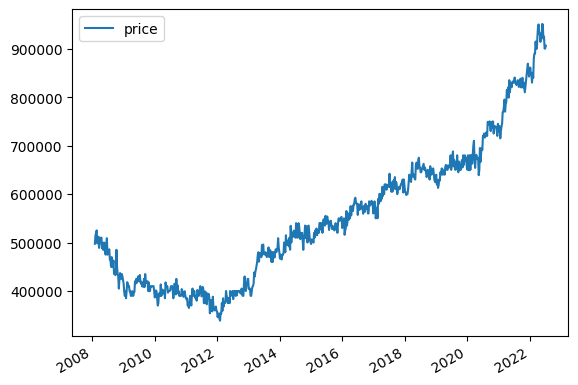

In [39]:
house_data.plot.line(y = 'price', use_index = True) #Our initial look at how the price of a house has gone up, but we need to also account for inflation

<Axes: >

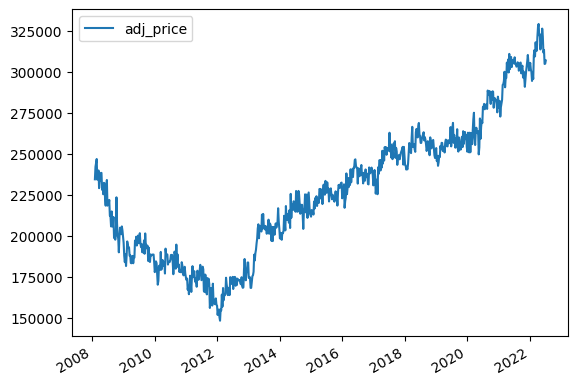

In [40]:
house_data['adj_price'] = house_data['price'] / house_data['cpi'] * 100 #This will account for inflation since 
house_data['adj_value'] = house_data['value'] / house_data['cpi'] * 100
house_data.plot.line(y = 'adj_price', use_index = True) #Here we see that the Y range has drastically lowered, but we can still see a upward trend of housing cost 

In [41]:
#Now we want to make our target value which is the future housing price in the next quarter 
house_data['next quarter'] = house_data['adj_price'].shift(-13) #This will grab the value from 13 weeks or 3.25 months
house_data = house_data.dropna()
house_data['change'] = (house_data['next quarter'] > house_data['adj_price']).astype(int) #This will make it so that if the price of house next quarter is higher than its 1 else its 0 
house_data

C:\Users\Daniel\AppData\Local\Temp\ipykernel_4868\2973668965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data['change'] = (house_data['next quarter'] > house_data['adj_price']).astype(int) #This will make it so that if the price of house next quarter is higher than its 1 else its 0


,interest,vacancy,cpi,price,value,adj_price,adj_value,next quarter,change
2008-02-02,5.68,10.1,212.174,497500.0,540174.638831,234477.362919,254590.401666,231171.703654,0
2008-02-09,5.67,10.1,212.687,515000.0,540174.638831,242139.858101,253976.330867,225363.369391,0
2008-02-16,5.72,10.1,212.687,520000.0,540174.638831,244490.73051,253976.330867,232333.370507,0
2008-02-23,6.04,10.1,212.687,525000.0,540174.638831,246841.602919,253976.330867,232101.037136,0
2008-03-01,6.24,10.1,212.687,498250.0,528354.938674,234264.435532,248419.009471,222575.368945,0
...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,914750.0,931407.638755,317943.887553,323733.660084,311687.344241,0
2022-03-19,4.16,5.8,287.708,900000.0,931407.638755,312817.161845,323733.660084,313211.073789,1
2022-03-26,4.42,5.8,287.708,900000.0,931407.638755,312817.161845,323733.660084,304745.909633,0
2022-04-02,4.67,5.8,287.708,925000.0,950811.533011,321506.527451,330477.961339,304915.212916,0


In [50]:
Start = 260 #We start using around 5 years of data 
Step = 52 #We leap through a year


predictors = ['interest', 'vacancy', 'adj_price', 'adj_value'] 
target = ['change']

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np 

#This is our model
def predict(train, test, predictors, target):
    rf = RandomForestClassifier(min_samples_split = 10, random_state = 1)
    rf.fit(train[predictors], train[target])
    preds = rf.predict(test[predictors])
    return preds

#Creating a backtesting engine
def backtest(data, predictors, target): #This will allow our model to make predictions without having future data trained on it 
    all_preds = []
    for i in range(Start, data.shape[0], Step):
        train = house_data.iloc[:i]
        test = house_data.iloc[i: (i + Step)]
        all_preds.append(predict(train, test, predictors, target))
        
    preds = np.concatenate(all_preds)
    return preds, accuracy_score(data.iloc[Start:][target],preds)

In [51]:
preds, accuracy = backtest(house_data, predictors, target)
accuracy

c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataCon

0.5324675324675324

In [44]:
#In order to improve our accuracy we can add more predictors 
yearly = house_data.rolling(52, min_periods=1).mean().copy()

yearly_ratios = [p + "_year" for p in predictors]
house_data[yearly_ratios] = house_data[predictors] / yearly[predictors]
house_data

C:\Users\Daniel\AppData\Local\Temp\ipykernel_4868\3688180426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data[yearly_ratios] = house_data[predictors] / yearly[predictors]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4868\3688180426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_data[yearly_ratios] = house_data[predictors] / yearly[predictors]
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4868\3688180426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,interest,vacancy,cpi,price,value,adj_price,adj_value,next quarter,change,interest_year,vacancy_year,adj_price_year,adj_value_year
2008-02-02,5.68,10.1,212.174,497500.0,540174.638831,234477.362919,254590.401666,231171.703654,0,1.000000,1.000000,1.0,1.0
2008-02-09,5.67,10.1,212.687,515000.0,540174.638831,242139.858101,253976.330867,225363.369391,0,0.999119,1.000000,1.016077,0.998793
2008-02-16,5.72,10.1,212.687,520000.0,540174.638831,244490.73051,253976.330867,232333.370507,0,1.005272,1.000000,1.017146,0.999195
2008-02-23,6.04,10.1,212.687,525000.0,540174.638831,246841.602919,253976.330867,232101.037136,0,1.045435,1.000000,1.02006,0.999396
2008-03-01,6.24,10.1,212.687,498250.0,528354.938674,234264.435532,248419.009471,222575.368945,0,1.063032,1.000000,0.974304,0.981941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,3.85,5.8,287.708,914750.0,931407.638755,317943.887553,323733.660084,311687.344241,0,1.235955,0.977317,1.049255,1.05239
2022-03-19,4.16,5.8,287.708,900000.0,931407.638755,312817.161845,323733.660084,313211.073789,1,1.326140,0.980494,1.031125,1.050158
2022-03-26,4.42,5.8,287.708,900000.0,931407.638755,312817.161845,323733.660084,304745.909633,0,1.397289,0.983692,1.030285,1.047935
2022-04-02,4.67,5.8,287.708,925000.0,950811.533011,321506.527451,330477.961339,304915.212916,0,1.462275,0.986911,1.056831,1.06706


In [45]:
preds, accuracy = backtest(house_data, predictors + yearly_ratios, target)
accuracy

c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataCon

0.564935064935065

C:\Users\Daniel\AppData\Local\Temp\ipykernel_4868\3655320998.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'green' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  pred_match[pred_match == True] = "green"


<Axes: xlabel='index', ylabel='adj_price'>

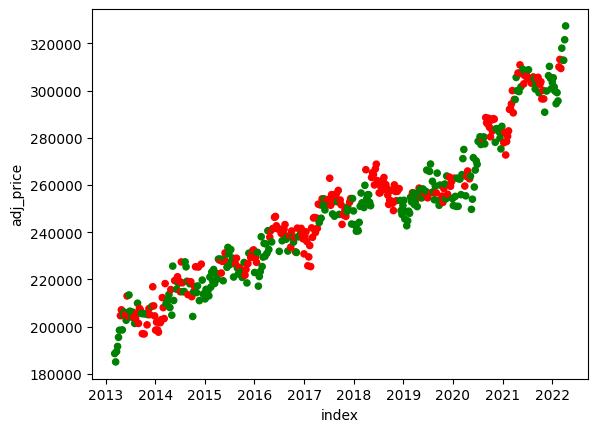

In [59]:
#Lets see which ones we got right or wrong 
pred_match = (preds == house_data['change'].iloc[Start:])
pred_match[pred_match == True] = "green"
pred_match[pred_match == False] = "red"

import matplotlib.pyplot as plt

plot_data = house_data.iloc[Start:].copy()

plot_data.reset_index().plot.scatter(x="index", y="adj_price", color=pred_match)

In [63]:
from sklearn.inspection import permutation_importance

rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(house_data[predictors], house_data[target])

result = permutation_importance(rf, house_data[predictors], house_data[target], n_repeats=10, random_state=1)
result['importances_mean']
#This shows us how important the different predictors were for predicting the change 

c:\Users\Daniel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([0.19833795, 0.20775623, 0.30512465, 0.20706371])

In [64]:
predictors

['interest', 'vacancy', 'adj_price', 'adj_value']